<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Generating explanations for an image-based model with Watson OpenScale

This notebook includes steps for importing a Keras deep learning model, deploying it in Watson machine Learning, then configuring Watson Open Scale to monitor this model and generate image classification predictions explanations.

### Contents
- [1. Setup](#setup)
- [2. Creating and deploying an image-based model](#deployment)
- [3. Subscriptions](#subscription)
- [4. Explainability](#explainability)

**Note**: In Watson Studio Cloud, run the notebook on at least 'Default Python 3.5 S' environment for faster operations.

<a id="setup"></a>
## 1. Setup

### 1.1 Install Watson OpenScale and WML packages

The follwoing cell will upgrade the WML and Watson OpenScale libraries to their latest version

The Watson OpenScale Python API is documented at http://ai-openscale-python-client.mybluemix.net/

In [1]:
try:
    import watson_machine_learning_client
    if not watson_machine_learning_client.utils.version().startswith('1.0.37'):
        raise ImportError()
except ImportError:
    !pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
    # !pip install watson-machine-learning-client==1.0.378
import watson_machine_learning_client
print(f"WML client library version is {watson_machine_learning_client.utils.version()}")

WML client library version is 1.0.376


2020-02-05 23:06:47,301 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2020-02-05 23:06:47,340 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2020-02-05 23:06:47,682 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:


In [2]:
try:
    import ibm_ai_openscale
    if not ibm_ai_openscale.utils.version().startswith('2.1.21'):
        raise ImportError()
except ImportError:
    !pip install --upgrade ibm-ai-openscale
    # !pip install ibm-ai-openscale==2.1.21
import ibm_ai_openscale
print(f"Watson OpenScale client library version is {ibm_ai_openscale.utils.version()}")

     |████████████████████████████████| 593kB 9.4MB/s eta 0:00:01
Watson OpenScale client library version is 2.1.21


> Note: You may need to restart the kernel to ensure that the newly installed libraries are being used.

### 1.2 Configure credentials

To run this Lab you need to have a valid instance of Watson Openscale.

To verify if you have one, go to the [cloud console](https://cloud.ibm.com/resources), clicking on `Services` you should see your Watson OpenScale instance listed.

if not then from that screen click the upper right button **"Create ressource"**.
From the search entry type 'openscale' and create a lite plan of Watson OpenScale.

You also need a valid **IBM Cloud API Key** to assign the variable in the next cell.

To get it go to the [IBM Cloud console](https://console.bluemix.net/) then click from the upper toolbar `Manage->Access (IAM)`. 
Select `IBM Cloud API Keys` from the left hand sidebar and then click the **"Create an IBM Cloud API Key"** button.

From that page, give your key a name and click Create, then copy the created key and paste it below. 

In [3]:
# @hidden_cell
CLOUD_API_KEY = "<insert your own CLOUD-API-KEY here>"

In [4]:
import ibm_ai_openscale

WOS_GUID = ibm_ai_openscale.utils.get_instance_guid(api_key=CLOUD_API_KEY)
AIOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(f"Got Watson OpenScale instance GUID {WOS_GUID}")

Got Watson OpenScale instance GUID bd9e971c-b24b-4286-9336-5f8d889e0320


You also need to have a valid instance of Watson Machine Learning (runtime for your models) running.

To verify if you have one, go to the [cloud console](https://cloud.ibm.com/resources), clicking on `Services` you should see your Watson Machine Learning instance listed.

if not then from that screen click the upper right button **"Create ressource"**.
From the search entry type 'Machine Learning' and create a lite plan of Watson Machine Learning. 
MAKE SURE THE REGION FIELD GOT **DALLAS** as value if not modify it accordingly.

From the IBM Cloud Resource list click on the Watson Machine Learning instance and from this page click the service credentials side bar item.
clik on view **'credentials'** and copy the all json info provided as follow :

```
{
  "apikey": "XXXXXXXXXX",
  "iam_apikey_description": "Auto-generated for key XXXX-YYYYY-ZZZZZZ",
  "iam_apikey_name": "WML-credentials",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/XXXXXXXX::serviceid:ServiceId-XXXX-YYYYYY-ZZZZZZZZ",
  "instance_id": "WWWWWWWWWWWWWWWW",
  "url": "https://us-south.ml.cloud.ibm.com"
}
```   
    

replace the following variable with the obtained json data.

In [5]:
# @hidden_cell
WML_CREDENTIALS = {
  "apikey": "xxxxxxxxxxxxxx",
  "iam_apikey_description": "Auto-generated for key yyyyyyyyyyyyy",
  "iam_apikey_name": "Service credentials-WML4JLC",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "instance_id": "xxxxxxx",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [6]:
# Utility function to wait for a certain amount of time
import sys, time

def Wait(seconds, Speed=5):
    Chars = ["|","/","-","\\"]
    MaxChars = len(Chars)
    sys.stdout.flush()
    for i in range(seconds*Speed):
        sys.stdout.write(f"\r{Chars[i % MaxChars]} {seconds-int(i/Speed)}")
        sys.stdout.flush()
        time.sleep(1/Speed)
    sys.stdout.write("\r         ")
#Wait(5)

<a id="deployment"></a>
## 2. Creating and deploying an image-based model

In the previous lab, we have generated and trained a NN Model for Handwritten Digit recognition based on the MNIST dataset, which consists in 60k 28x28 grayscale images of the 10 digits, along with a test set of 10k images.    
More information about the dataset can be found here: https://keras.io/datasets/#mnist-database-of-handwritten-digits

We could reuse this model here, for the sake of simplicity, a trained model file is also provided with this lab material

if you don't want to train the model during this lab, which is quite time consumming (15 mn average) depending on the size of your python/jupyter environment, you can use a pre-trained model provided to you with this notebook file.
You also have the definition and trained weights of the model in a file called **HandWrittenDigit-CNN.h5**

**Keras also supports a simpler interface to save both the model weights and model architecture together into a single H5 file, 
while the HDF5 format store only Model weights and therefore the model architecture is provided as a JSON format.**
    
* Saving/Loading the model in H5 includes everything we need to know about the model, including:
    - Model weights.
    - Model architecture.
    - Model compilation details (loss and metrics).
    - Model optimizer state.
* This means that we can load and use the model directly, without having to re-compile it.

To upload the HD5 file and use it please procedd as follow :

From the upper toolbar select the 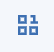 icon and Files tab, then drop the  **HandWrittenDigit-CNN.h5** file provided in the box folder onto the drop area: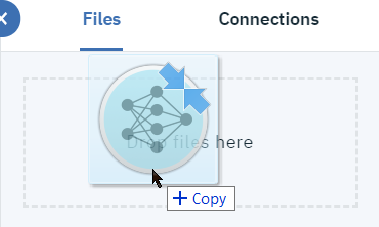 to create a data asset for it.

Move your cursor on the cell bellow and remove everything (cell fully empty !)

Once done click the drop down arrow of the right hand side window where **HandWrittenDigit-CNN.h5** is and select **insert to code>>Insert Credentials**

The equivalent cell should now have your own credentials, which will be used in the subsequent cells to load the model.

This enables to use the already trained model's `HD5` definition and weights instead of having to retrain it.

In [7]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-c4f0e073-8745-4c4b-863a-24cc81ae65ee',
    'IBM_API_KEY_ID': 'sU4LuSImRo70PbrprlSBQOHouuKmrgzU5BaGpToanDLO',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'watsonstudiows2020-donotdelete-pr-gyityavxovtrbp',
    'FILE': 'HandWrittenDigit-CNN.h5'
}

In [8]:
import ibm_boto3
from botocore.client import Config

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
Client_COS = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials_1['ENDPOINT'])
ModelFile = credentials_1['FILE']

We now download the trained model file to the local (transient) filesystem and load it as a Keras model

In [9]:
import keras

Client_COS.download_file(Bucket=credentials_1['BUCKET'], Key=ModelFile,Filename=ModelFile)
cnn_n = keras.models.load_model(ModelFile)
cnn_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### 2.1 Accessing and cleaning-up WML

We access WML and clean-up some of the artifacts

In [10]:
import watson_machine_learning_client

wml_client = watson_machine_learning_client.WatsonMachineLearningAPIClient(WML_CREDENTIALS)
predUsage=wml_client.service_instance.details.get('entity').get('usage').get('prediction_count')
predCur,predLim=int(predUsage.get('current')),int(predUsage.get('limit'))
print(f"WML instance predictions usage {predCur} out of {predLim} {(100*predCur)/predLim:.2f} %")

# This is the name we will use for our model explanations
model_name = "MNISTModelExp"

WML instance predictions usage 16 out of 1000000 0.00 %


### Optional cleanup
Running the following cell is optional, it will clean-up the WML repository of artifacts that may have been generated by successive runs of this code

In [12]:
# Clean-up past models and artifacts with the same name
defs=wml_client.repository.get_definition_details()
names={r.get('entity').get('name') for r in defs.get('resources')}
print(f"Definitions names={[n for n in names]}")
for g in [r.get('metadata').get('guid') for r in defs.get('resources') if r.get('entity').get('name')==model_name]:
    print(f"Deleting definition {g}: {wml_client.repository.delete_definition(g)}")
    
mods=wml_client.repository.get_model_details()
names={r.get('entity').get('name') for r in mods.get('resources')}
print(f"Models names={[n for n in names]}")
for g in [r.get('metadata').get('guid') for r in mods.get('resources') if r.get('entity').get('name')==model_name]:
    print(f"Deleting definition {g}: {wml_client.repository.delete(g)}")
    
wml_client.repository.list()

Definitions names=['KerasMNIST', 'Spark German Risk Model - Final']
Models names=['GermanCreditRiskModel', 'Table', 'Spark German Risk Model - Final']
------------------------------------  ------------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK          TYPE
a55c5f6a-3873-4592-ac0e-d963fee7767d  Spark German Risk Model - Final       2020-01-20T23:14:49.517Z  mllib              definition
bb167223-0a3f-4f6b-9f1f-de761370f4cc  KerasMNIST                            2020-01-16T17:27:12.073Z  tensorflow         definition
14a2893d-dd83-45a6-b480-c50c3c2cda4e  Table                                 2020-01-22T16:05:56.367Z  spss-modeler-18.1  model
f40f029d-3bf3-41e0-a3ac-6bc14506b6a6  GermanCreditRiskModel                 2020-01-22T09:16:39.485Z  mllib-2.3          model
9440a1ee-b555-4860-8768-70c976342323  Spark German Risk Model - Fi

## Save and deploy model to be Explained in WML

### 2.2 Storing the model into WML

We will store back this model into Watson Machine Learning model repository so that Watson OpenScale can make use of it

We use Keras to generate the model to a local file and then run GZip on it for referencing as WML metadata

In [13]:
# Save the model and package it as a gzipped tar
modelFile='mnist_cnn.h5'
modelFileZipped='mnist_cnn.tar.gz'
cnn_n.save(modelFile)
!if [ -f {modelFileZipped} ]; then rm {modelFileZipped}; fi
!tar -czf {modelFileZipped} {modelFile}

# Update the FRAMEWORK_VERSION below depending on the tensorflow version used
published_model_details = wml_client.repository.store_model(model=modelFileZipped,
    meta_props= {
        wml_client.repository.ModelMetaNames.NAME: model_name,
        wml_client.repository.ModelMetaNames.DESCRIPTION: "MNIST model to Explain",
        wml_client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
        wml_client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.13",
        wml_client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{"name": "keras", "version": "2.2.4"}]
    })
print(f"Model stored, guid={published_model_details.get('metadata').get('guid')}")

Model stored, guid=7fbfe96d-8688-44ce-9a59-2409f6ae3d83


### 2.3 Deploying the model
We will now deploy the model in WML, using the metadata defined above

In [14]:
model_uid = wml_client.repository.get_model_uid(published_model_details)
deployment= wml_client.deployments.create(name= f"{model_name} Deployment", model_uid=model_uid)
scoring_url = wml_client.deployments.get_scoring_url(deployment)
print(f"Model {model_name} with UID {model_uid} deployed, at URL {scoring_url}")



#######################################################################################

Synchronous deployment creation for uid: '7fbfe96d-8688-44ce-9a59-2409f6ae3d83' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d2d42899-b1ca-42c8-82a8-9ddee9a742f1'
------------------------------------------------------------------------------------------------


Model MNISTModelExp with UID 7fbfe96d-8688-44ce-9a59-2409f6ae3d83 deployed, at URL https://us-south.ml.cloud.ibm.com/v3/wml_instances/b56805ef-6249-4925-8876-044f9b42e446/deployments/d2d42899-b1ca-42c8-82a8-9ddee9a742f1/online


## 3. Subscriptions
Subscriptions is the means by which Watson OpenScale plugs into Watson Machine Learning to monitor scoring operations on a given deployed model.

### 3.1 Configuring OpenScale
Here we gain access to the Watson OpenScale API

In [15]:
import ibm_ai_openscale

aios_client = ibm_ai_openscale.APIClient(AIOS_CREDENTIALS)
print(f"Using IBM OpenScale client version {aios_client.version}")
aios_client.data_mart.subscriptions.list()

Using IBM OpenScale client version 2.1.21


4572a5ca-fd79-4acd-abb1-7f3cb47d18bc,MNISTModelExp,model,b56805ef-6249-4925-8876-044f9b42e446,2020-02-05T19:03:54.941Z


In [16]:
# Get subscription for our model
# Note that if you have been running this code already, this cell finds out the existing subscription details
subsUID=[d.get('metadata').get('guid') for d in aios_client.data_mart.subscriptions.get_details().get('subscriptions') if d.get('entity').get('asset').get('name')==model_name]

subscription=None
if len(subsUID)>0:
    subscription=aios_client.data_mart.subscriptions.get(subsUID[0])
    print(f"Found an existing subscription {subsUID[0]} for model with name {model_name}")

Found an existing subscription 4572a5ca-fd79-4acd-abb1-7f3cb47d18bc for model with name MNISTModelExp


> Optional clean-up of previous subscription entries

In [18]:
# CLEAN-UP Subscription entries
# NOTE that this cell is optional, used to clean-up after successive runs
subscriptions_uids = aios_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = aios_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == model_name:
        aios_client.data_mart.subscriptions.delete(subscription)
        print(f"Deleted existing subscription for {model_name}")

### 3.2 Subscribe to the model asset
Watson OpenScale will now be set-up to subscribe to the model as an asset

This will allow OpenScale to capture scoring requests against the model and produce explanability output

In [19]:
# Create an asset for the model to be monitored
model_asset = ibm_ai_openscale.engines.WatsonMachineLearningAsset(
    model_uid,
    problem_type=ibm_ai_openscale.supporting_classes.enums.ProblemType.MULTICLASS_CLASSIFICATION,
    input_data_type=ibm_ai_openscale.supporting_classes.enums.InputDataType.UNSTRUCTURED_IMAGE,
    probability_column='probability')
subscription = aios_client.data_mart.subscriptions.add(model_asset)
aios_client.data_mart.subscriptions.list()

604d794e-27c3-4e7d-b138-6858cc903176,MNISTModelExp,model,b56805ef-6249-4925-8876-044f9b42e446,2020-02-05T23:08:09.375Z


### 3.3 Score the model and get transaction-id
In order to run Watson OpenScale explanability against the Keras model, we will need to generate scoring events.

For this we will first load some test data for the MNIST model

In [20]:
import keras

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Selecting an subset of images to run explanability against
We will define below the count of images to explain. Note that when using the free lite account, the number of explanaible transactions is limited.   
Here we will elect to explain 8 images predictions

We will also select an image to start with, arbitrarily somewhere within the dataset.
As an alternative, the next cell is scoring the model for a set of predictions in order to find a wrongly predicted image as starting point. To enable this, set the `imgOffset` value to `None`

In [21]:
# Configure how many images we want to deal with for explanability, and which image to start with
imgCnt=8
imgOffset=75

In [22]:
# For the sake of exemplarity, we will seek for one of the test elements which is predicted wrong
import numpy as np
if imgOffset is None:
    for i,x in enumerate(x_test):
        y=cnn_n.predict_classes(np.array([x]))
        if y[0] != y_test[i] :
            # Use this as one of our image to be explained
            imgOffset=i
            print(f"Starting with image at offset {i}, which is an actual {y_test[i]} but predicted by the model as a {y[0]}")
            break
else:
    print(f"Starting with image at offset {imgOffset}")

Starting with image at offset 75


### Execute a scoring transaction through Watson Machine Learning
Watson OpenScale has been setup to observe WML scoring transactions through the subscription setup above, we will now score the images to be explained

In [23]:
# Score the  digits with WML, so as to get the prediction confidence
scoring_data = {'values': [x_test[d+imgOffset].tolist() for d in range(0,imgCnt)]}
predictions = wml_client.deployments.score(scoring_url, scoring_data)['values']

In [24]:
print(f"Actual values:    {[f'{y_test[d+imgOffset]:^7}' for d in range(0,imgCnt)]}")
print(f"Predicted values: {[f'{p[1]:^7}' for p in predictions]}")
print(f"Confidence:       {[f'{100*p[0][p[1]]:^6.1f}%' for p in predictions]}")

Actual values:    ['   7   ', '   3   ', '   2   ', '   9   ', '   7   ', '   7   ', '   6   ', '   2   ']
Predicted values: ['   7   ', '   3   ', '   2   ', '   9   ', '   7   ', '   7   ', '   6   ', '   2   ']
Confidence:       ['100.0 %', '100.0 %', '100.0 %', ' 91.6 %', '100.0 %', '100.0 %', '100.0 %', '100.0 %']


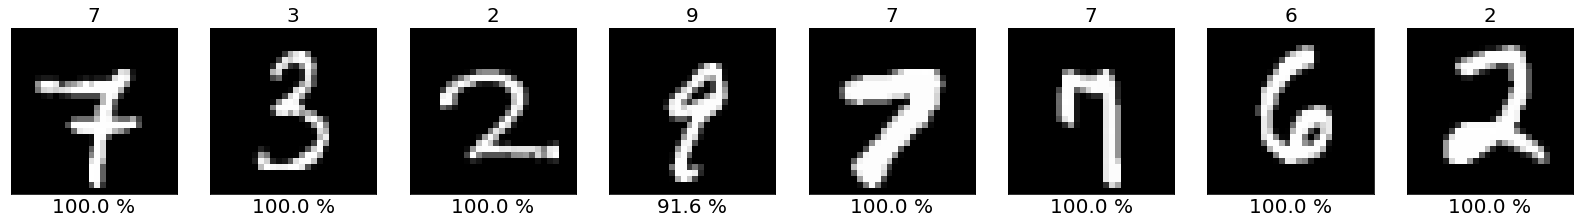

In [25]:
# Display the input images
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f, axarr = plt.subplots(1,imgCnt,figsize=(28, 28))

for d in range(0,imgCnt):
    axarr[d].set_xticks(())
    axarr[d].set_yticks(())
    axarr[d].set_title(f"{predictions[d][1]}")
    axarr[d].title.set_fontsize(20)
    axarr[d].set_xlabel(f"{100*predictions[d][0][predictions[d][1]]:.1f} %")
    axarr[d].xaxis.label.set_fontsize(20)
    axarr[d].imshow(np.array(x_test[d+imgOffset], dtype='float').reshape((img_cols, img_rows)), cmap='gray')
plt.show()
#print(f"labels: {[y_test[d+imgOffset] for d in range(0,imgCnt)]}")

## Show the scorings recorded through the subscription
Now we will look into the data Watson OpenScale has logged during the WML scoring operations which it has subscribed to

In [26]:
table_content=subscription.payload_logging.get_table_content()
scoring_ids=table_content.scoring_id
if len(scoring_ids)>0: 
    print(f"There are {len(scoring_ids)} scorings recorded in the subscription, we can now request explanations")
else:
    print(f"No scorings recorded yet, there may be a delay after scoring before the payloads get stored, waiting...")
    Wait(5)

There are 8 scorings recorded in the subscription, we can now request explanations


<a id="explainability"></a>
## 4. Explainability
We will now setup Watson OpenScale's explanability feature for the subscription to the model

### 4.1 Configure Explainability

In [27]:
subscription.explainability.enable()
subscription.explainability.get_details()

{'enabled': True, 'parameters': {}}

### 4.2 Get explanation for the transaction
We will now ask Watson OpenScale to generate explanations for the previously monitored and recorded transactions

In [28]:
try :
    explanations = [subscription.explainability.run(s, background_mode=False,cem=True) for s in scoring_ids]
except Exception as exc:
    print(f"Something went wrong, exception {exc}")
    wml_client.repository.delete(model_uid)
    deployment_id = wml_client.deployments.get_uid(deployment)
    wml_client.deployments.delete(deployment_id)




 Looking for explanation for a4207adb3488b2c695bb5c947234a6d1-1 




in_progress.....
finished

---------------------------
 Successfully finished run 
---------------------------





 Looking for explanation for a4207adb3488b2c695bb5c947234a6d1-2 




in_progress..
finished

---------------------------
 Successfully finished run 
---------------------------





 Looking for explanation for a4207adb3488b2c695bb5c947234a6d1-3 




in_progress..
finished

---------------------------
 Successfully finished run 
---------------------------





 Looking for explanation for a4207adb3488b2c695bb5c947234a6d1-4 




in_progress.
finished

---------------------------
 Successfully finished run 
---------------------------





 Looking for explanation for a4207adb3488b2c695bb5c947234a6d1-5 




in_progress.
finished

---------------------------
 Successfully finished run 
---------------------------





 Looking for explanation for a4207adb3488b2c695bb5c947234a6d1-6 




in_progress
finis

If you get an error in the previous cell, with a message something ending by **KeyError: 'cem_state'** it's due to a bug in the python library.

To circumvent this, you can collect the `transaction_id`s from the cell above and use it in the Watson OpenScale UI at https://aiopenscale.cloud.ibm.com/aiopenscale/explain to get the result of the image model explainability for that transaction.
    
**Explaining image model transactions**

For an image classification model example of explainability, you can see which parts of an image contributed positively to the predicted outcome and which contributed negatively. In the following example, the image in the positive pane shows the parts which impacted positively to the prediction and the image in the negative pane shows the parts of images that had a negative impact on the outcome.

The code below will display the positive, original and negative contributions respectively

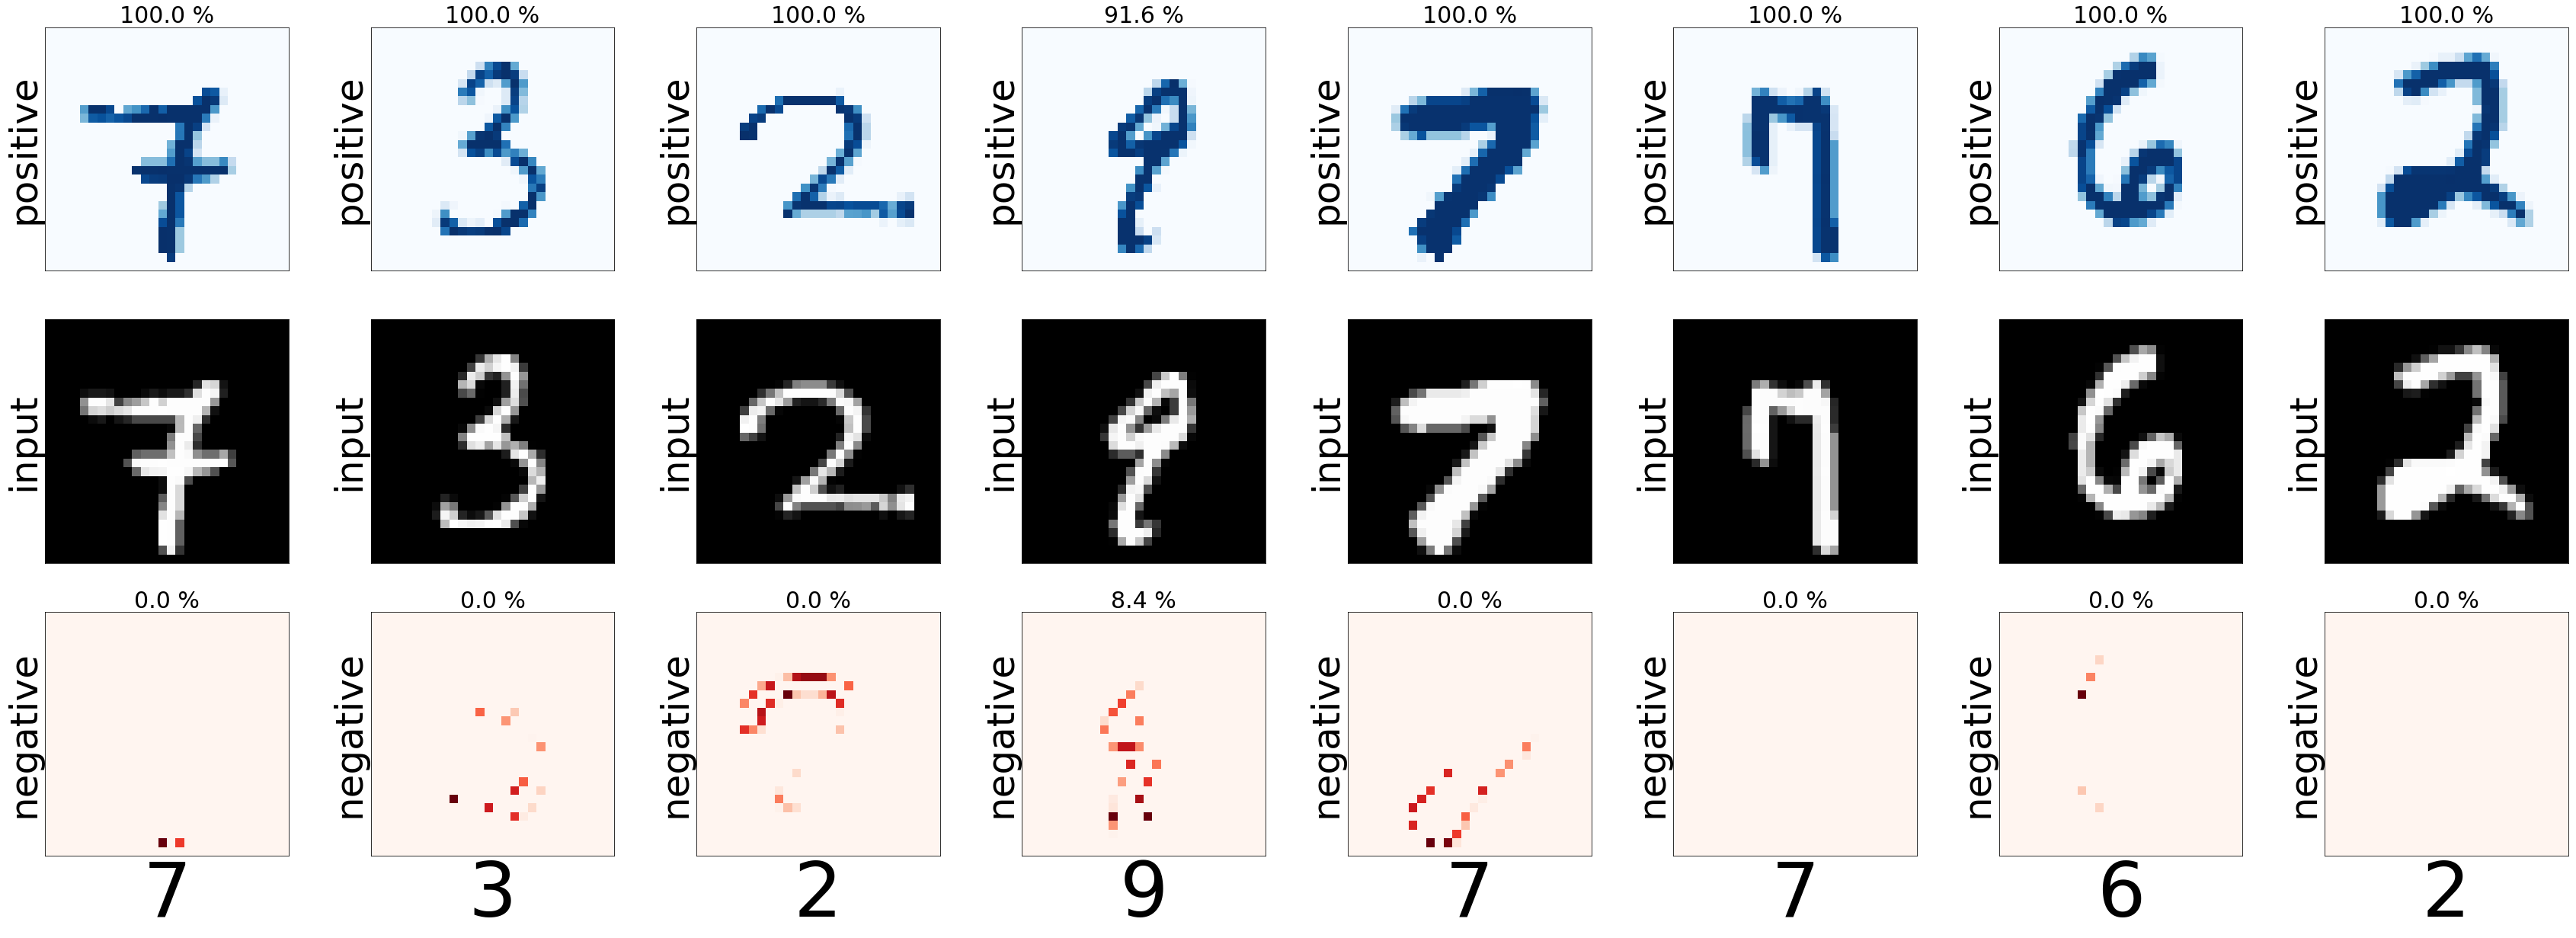

In [30]:
import io, base64

cmaps=['Blues',None,'Reds']
f, axarr = plt.subplots(len(cmaps),len(explanations),figsize=(len(cmaps)*20,20))

for ie, e in enumerate([e['entity'] for e in explanations if e]):
    y_pred=table_content.prediction_classes[ie]
    preds=[e['predictions'][i] for i in (0,1)]
    descs=[preds[0]['value'],'input',preds[1]['value']]
    if not 'probability' in preds[1].keys(): preds[1]['probability']=0.0 # Fix for transient issue...
    titles=[f"{100*preds[0]['probability']:.1f} %",None,f"{100*preds[1]['probability']:.1f} %"]
    
    imgs=[plt.imread(io.BytesIO(base64.b64decode(img))) for img in
          [preds[0]['explanation'][0]['full_image'], e['input_features'][0]['full_image'], preds[1]['explanation'][0]['full_image']]]

    for ii, img in enumerate(imgs):
        # Add text to the images axes
        ax=axarr[ii,ie]
        ax.set_xticks(())
        ax.set_yticks(())
        if ii==len(imgs)-1: ax.set_xlabel(f"{y_pred}",{'fontsize':100})
        ax.set_ylabel(descs[ii],{'fontsize':50})
        ax.set_title(titles[ii],{'fontsize':30})
        
        if cmaps[ii]:
            # change to gray scale, so as to use a colormap
            ax.imshow(np.array([[img[x,y][0] for y in range(0,img.shape[1])] for x in range(0,img.shape[0])]),cmap=cmaps[ii])
        else:
            ax.imshow(img)
        #elif ii==1: ax.imshow(img)
        #else : ax.imshow(img2,cmap='Reds')
plt.show()